# Handwritten Devnagari Character classification
### Author: Sanjay Jaras
### Bellevue University

## Import Libraries

In [1]:
import os
from IPython.display import clear_output
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import random
import PIL
from PIL import Image
from skimage.transform import resize
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMClassifier
from xgboost.sklearn import XGBClassifier
import seaborn as sns
from sklearn import svm


## Configurations

In [2]:
random_state = 17
np.random.seed(random_state)
import warnings
warnings.filterwarnings('ignore')

## Define datasource paths

In [3]:
base_path = "DevanagariHandwrittenCharacterDataset"
#base_path = "../input/devnagrihandwrittenchars/DevanagariHandwrittenCharacterDataset"
train_path = os.path.join(base_path, "Train")
test_path = os.path.join(base_path, "Test")


## Function to scan the folders and load images in array. 

In [4]:
def load_image_to_array(file_path):
    with open(file_path, "rb") as f:
        img = PIL.Image.open(f)
        nparr = np.asarray(img)
        # plt.imshow(nparr)
        #nparr = nparr[:, :, np.newaxis]
        return nparr


def read_data_from_folder(folder_path, read_first_record_only=False):
    imgs = []
    labels = []
    for folder in tqdm(os.listdir(folder_path)):
        sub_folder = os.path.join(folder_path, folder)
        for f in os.listdir(sub_folder):
            img = load_image_to_array(os.path.join(sub_folder, f))
            imgs.append(img)
            labels.append(folder)
            if read_first_record_only:
                break
    return np.asarray(imgs), np.asarray(labels)


## Sample images from all source folders

In [5]:
sample_imgs, sample_labels = read_data_from_folder(train_path, True)
sample_imgs.shape


100%|██████████| 46/46 [00:00<00:00, 917.22it/s]


(46, 32, 32)

## Function to Display Images

In [6]:
def display_image(imgarr):
    plt.figure(figsize=(20, 40))
    for i in range(len(imgarr)):
        plt.subplot(46, 6, i+1)
        img = resize(imgarr[i], [100, 100])
        plt.imshow(img)
        plt.axis('off')
    plt.show()


## Show one sample image from each of input training folder

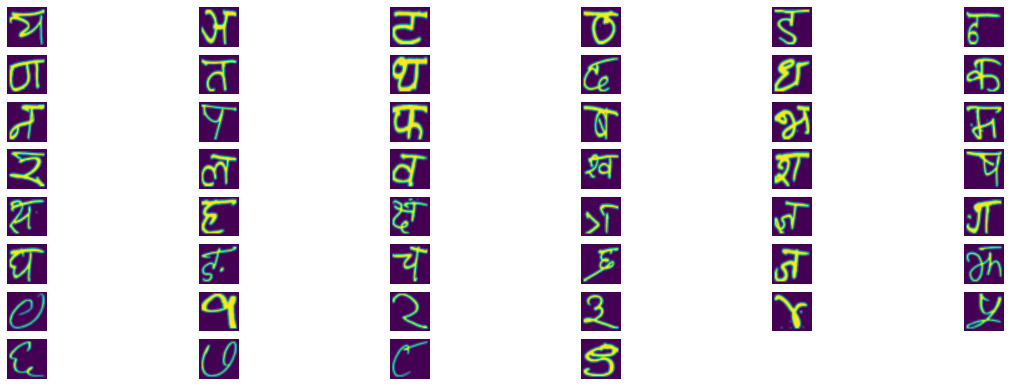

In [7]:
display_image(sample_imgs)

## Load Training and Test Dataset

In [8]:
print("Loading training data....")
train_data_img, train_data_labels = read_data_from_folder(train_path)
print("Loading test data....")
test_data_imgs, test_data_labels = read_data_from_folder(test_path)


Loading training data....


100%|██████████| 46/46 [00:11<00:00,  4.03it/s]


Loading test data....


100%|██████████| 46/46 [00:02<00:00, 21.82it/s]


## Display Dataset shapes

In [9]:
print("Training data imgs shape", train_data_img.shape)
print("Training data labels shape", train_data_labels.shape)
print("Test data imgs shape", test_data_imgs.shape)
print("Test data labels shape", test_data_labels.shape)


Training data imgs shape (78200, 32, 32)
Training data labels shape (78200,)
Test data imgs shape (13800, 32, 32)
Test data labels shape (13800,)


## Reshape dataset to use with models

In [10]:
train_data_img = train_data_img.reshape(train_data_img.shape[0], train_data_img.shape[1] * train_data_img.shape[2])
test_data_imgs = test_data_imgs.reshape(test_data_imgs.shape[0], test_data_imgs.shape[1] * test_data_imgs.shape[2])

In [11]:
print("Training data imgs shape", train_data_img.shape)
print("Training data labels shape", train_data_labels.shape)
print("Test data imgs shape", test_data_imgs.shape)
print("Test data labels shape", test_data_labels.shape)

Training data imgs shape (78200, 1024)
Training data labels shape (78200,)
Test data imgs shape (13800, 1024)
Test data labels shape (13800,)


## Add column for label in dataframe

In [12]:
train_df = pd.DataFrame(train_data_img)
train_df["label"] = train_data_labels

In [13]:
train_df

,0,1,2,3,4,5,6,7,8,9,...,1015,1016,1017,1018,1019,1020,1021,1022,1023,label
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,character_26_yaw
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,character_26_yaw
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,character_26_yaw
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,character_26_yaw
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,character_26_yaw
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78195,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,digit_9
78196,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,digit_9
78197,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,digit_9
78198,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,digit_9


In [14]:
test_df = pd.DataFrame(test_data_imgs)
test_df["label"] = test_data_labels

In [15]:
test_df

,0,1,2,3,4,5,6,7,8,9,...,1015,1016,1017,1018,1019,1020,1021,1022,1023,label
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,character_26_yaw
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,character_26_yaw
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,character_26_yaw
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,character_26_yaw
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,character_26_yaw
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13795,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,digit_9
13796,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,digit_9
13797,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,digit_9
13798,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,digit_9


## Class to normalize

In [16]:
class Normalizer(BaseEstimator, TransformerMixin):
    def __init__(self, labelCol ):
        self.labelCol = labelCol

    def transform(self, df):
        for attr in  tqdm(df.columns):
            if attr != self.labelCol:
                df[attr] = df[attr]/255.0
        return df

    def fit(self, X, y = None):
        return self


In [17]:
normalizer = Normalizer("label")
train_new = normalizer.transform(train_df)
#train_new[122]

100%|██████████| 1025/1025 [00:05<00:00, 171.60it/s]


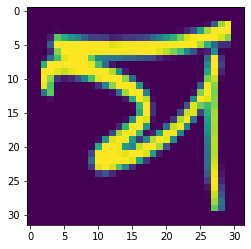

In [18]:
a = np.array(train_df.iloc[0][:1024], dtype='float')
a = a.reshape(32,32)
plt.imshow(a)

## Class for label encoding

In [19]:
class MyLabelEncoder(LabelEncoder):
    def __init__(self, labelCol ):
        self.labelCol = labelCol

    def transform(self, df):
        df[self.labelCol] = LabelEncoder.transform(self, df[self.labelCol])
        return df

    def fit(self, X, y = None):
        LabelEncoder.fit(self, X[self.labelCol])
        return self

## classes Available

In [20]:
labelEncoder = MyLabelEncoder("label")
labelEncoder.fit(train_df)

labelEncoder.classes_
# array([1, 2, 6])
#labelEncoder.transform(['character_10_yna', 'character_11_taamatar', 'character_12_thaa','character_13_daa'])
# array([0, 0, 1, 2]...)
# >>> le.inverse_transform([0, 0, 1, 2])
# array([1, 1, 2, 6])

array(['character_10_yna', 'character_11_taamatar', 'character_12_thaa',
       'character_13_daa', 'character_14_dhaa', 'character_15_adna',
       'character_16_tabala', 'character_17_tha', 'character_18_da',
       'character_19_dha', 'character_1_ka', 'character_20_na',
       'character_21_pa', 'character_22_pha', 'character_23_ba',
       'character_24_bha', 'character_25_ma', 'character_26_yaw',
       'character_27_ra', 'character_28_la', 'character_29_waw',
       'character_2_kha', 'character_30_motosaw',
       'character_31_petchiryakha', 'character_32_patalosaw',
       'character_33_ha', 'character_34_chhya', 'character_35_tra',
       'character_36_gya', 'character_3_ga', 'character_4_gha',
       'character_5_kna', 'character_6_cha', 'character_7_chha',
       'character_8_ja', 'character_9_jha', 'digit_0', 'digit_1',
       'digit_2', 'digit_3', 'digit_4', 'digit_5', 'digit_6', 'digit_7',
       'digit_8', 'digit_9'], dtype=object)

## Create pipeline

In [21]:
transform_pipeline = Pipeline([("Normalizer",  normalizer), ("label-encode", labelEncoder)])

## Apply transformation pipeline

In [22]:
train_df = transform_pipeline.transform(train_df)

test_df = transform_pipeline.transform(test_df)

100%|██████████| 1025/1025 [00:00<00:00, 1246.53it/s]


## Split input and labels in separate dataframes

In [23]:
train_X = train_df.loc[:, train_df.columns != "label"]
train_Y = train_df["label"]
test_X = test_df.loc[:, test_df.columns != "label"]
test_Y = test_df["label"]

In [24]:
cv = RepeatedStratifiedKFold(n_splits=2, n_repeats=1, random_state=random_state)

## Create sample dataset for grid search

In [25]:
#import sklearn
#sklearn.metrics.SCORERS.keys()
train_x_grid = train_X[0:1]
train_y_grid = train_Y[0:1]
cnt = 100
num_rec_per_class = 1700
for i in range(0, train_X.shape[0]//46):
    #print(i*num_rec_per_class, i*num_rec_per_class+cnt)
    train_x_grid = np.append(train_x_grid, train_X[i*num_rec_per_class:i*num_rec_per_class+cnt], axis=0)
    train_y_grid = np.append(train_y_grid, train_Y[i*num_rec_per_class:i*num_rec_per_class+cnt], axis=0)
    #train_x_grid.append(train_X[i*num_rec_per_class:i*num_rec_per_class+cnt])
print(np.array(train_x_grid).shape)
print(np.array(train_y_grid).shape)

(4601, 1024)
(4601,)


## Grid Search

In [26]:
param_grid = [
    {'n_neighbors': [5, 20, 50], 'leaf_size': [10, 20, 30]},
    {'min_weight_fraction_leaf': [0, 0.2, 0.5]},
    {'n_estimators': [100, 200, 300]},
    #{'learning_rate': [0.1, 0.3], 'max_depth':[10, 30], 'n_estimators':[50, 100, 150]},
    {'learning_rate': [0.1, 0.3], 'max_depth':[
        10, 30, -1], 'n_estimators':[50, 100, 150]},
    # {'learning_rate': [0.1, 0.3], 'max_depth':[10, 30, -1], 'n_estimators':[50, 100, 150]},
    {'degree': [3, 10, 20], 'decision_function_shape': ['ovo', 'ovr']}

]
estimators = [
    KNeighborsClassifier(),
    DecisionTreeClassifier(random_state=random_state),
    RandomForestClassifier(random_state=random_state),
    #GradientBoostingClassifier(random_state= random_state),
    LGBMClassifier(random_state=random_state),
    #XGBClassifier(random_state= random_state, use_label_encoder=False),random_state
    svm.SVC(random_state=random_state)
]
# 'kernel': ['linear', 'poly', 'rbf', 'sigmoid', 'precomputed'],
grid_result = []
for i in tqdm(range(len(estimators))):
    print("*" * 100)
    print("Evaluating Model", estimators[i].__class__.__name__)
    grid_reg = GridSearchCV(
        estimators[i], param_grid=param_grid[i], cv=cv, verbose=10, n_jobs=12, scoring="f1_macro")
    grid_reg.fit(train_x_grid, train_y_grid)
    print("Best Score:", grid_reg.best_score_)
    print("Best Params:", grid_reg.best_params_)
    grid_result.append(grid_reg)


  0%|          | 0/5 [00:00<?, ?it/s]

****************************************************************************************************
Evaluating Model KNeighborsClassifier
Fitting 2 folds for each of 9 candidates, totalling 18 fits
[CV 1/2; 2/9] START leaf_size=10, n_neighbors=20................................
[CV 2/2; 1/9] START leaf_size=10, n_neighbors=5.................................[CV 1/2; 1/9] START leaf_size=10, n_neighbors=5.................................

[CV 2/2; 2/9] START leaf_size=10, n_neighbors=20................................
[CV 1/2; 3/9] START leaf_size=10, n_neighbors=50................................
[CV 2/2; 3/9] START leaf_size=10, n_neighbors=50................................
[CV 1/2; 6/9] START leaf_size=20, n_neighbors=50................................
[CV 1/2; 4/9] START leaf_size=20, n_neighbors=5.................................
[CV 2/2; 4/9] START leaf_size=20, n_neighbors=5.................................
[CV 1/2; 5/9] START leaf_size=20, n_neighbors=20........................

 20%|██        | 1/5 [00:01<00:06,  1.67s/it]

Best Score: 0.7612438498239373
Best Params: {'leaf_size': 10, 'n_neighbors': 5}
****************************************************************************************************
Evaluating Model DecisionTreeClassifier
Fitting 2 folds for each of 3 candidates, totalling 6 fits
[CV 1/2; 2/3] START min_weight_fraction_leaf=0.2................................
[CV 1/2; 1/3] START min_weight_fraction_leaf=0..................................
[CV 2/2; 2/3] START min_weight_fraction_leaf=0.2................................
[CV 2/2; 1/3] START min_weight_fraction_leaf=0..................................
[CV 1/2; 3/3] START min_weight_fraction_leaf=0.5................................
[CV 2/2; 3/3] START min_weight_fraction_leaf=0.5................................
[CV 1/2; 3/3] END .min_weight_fraction_leaf=0.5;, score=0.003 total time=   0.1s
[CV 2/2; 3/3] END .min_weight_fraction_leaf=0.5;, score=0.001 total time=   0.1s
[CV 1/2; 2/3] END .min_weight_fraction_leaf=0.2;, score=0.007 total time

 40%|████      | 2/5 [00:04<00:06,  2.18s/it]

Best Score: 0.4090657739714598
Best Params: {'min_weight_fraction_leaf': 0}
****************************************************************************************************
Evaluating Model RandomForestClassifier
Fitting 2 folds for each of 3 candidates, totalling 6 fits
[CV 1/2; 1/3] START n_estimators=100............................................
[CV 2/2; 1/3] START n_estimators=100............................................
[CV 1/2; 2/3] START n_estimators=200............................................
[CV 2/2; 2/3] START n_estimators=200............................................[CV 1/2; 3/3] START n_estimators=300............................................

[CV 2/2; 3/3] START n_estimators=300............................................
[CV 2/2; 1/3] END .............n_estimators=100;, score=0.812 total time=   2.0s
[CV 1/2; 1/3] END .............n_estimators=100;, score=0.784 total time=   2.1s
[CV 1/2; 2/3] END .............n_estimators=200;, score=0.798 total time=   

 60%|██████    | 3/5 [00:21<00:17,  8.86s/it]

Best Score: 0.8144522073278911
Best Params: {'n_estimators': 300}
****************************************************************************************************
Evaluating Model LGBMClassifier
Fitting 2 folds for each of 18 candidates, totalling 36 fits
[CV 1/2; 6/18] START learning_rate=0.1, max_depth=30, n_estimators=150..........
[CV 2/2; 3/18] START learning_rate=0.1, max_depth=10, n_estimators=150..........
[CV 1/2; 1/18] START learning_rate=0.1, max_depth=10, n_estimators=50...........
[CV 2/2; 1/18] START learning_rate=0.1, max_depth=10, n_estimators=50...........
[CV 2/2; 6/18] START learning_rate=0.1, max_depth=30, n_estimators=150..........
[CV 1/2; 4/18] START learning_rate=0.1, max_depth=30, n_estimators=50...........
[CV 1/2; 3/18] START learning_rate=0.1, max_depth=10, n_estimators=150..........
[CV 2/2; 2/18] START learning_rate=0.1, max_depth=10, n_estimators=100..........
[CV 2/2; 5/18] START learning_rate=0.1, max_depth=30, n_estimators=100..........
[CV 2/2; 4/

 80%|████████  | 4/5 [08:46<03:24, 204.83s/it]

Best Score: 0.7327590297920007
Best Params: {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 150}
****************************************************************************************************
Evaluating Model SVC
Fitting 2 folds for each of 6 candidates, totalling 12 fits
[CV 1/2; 1/6] START decision_function_shape=ovo, degree=3.......................
[CV 2/2; 1/6] START decision_function_shape=ovo, degree=3.......................
[CV 1/2; 2/6] START decision_function_shape=ovo, degree=10......................
[CV 2/2; 2/6] START decision_function_shape=ovo, degree=10......................
[CV 1/2; 3/6] START decision_function_shape=ovo, degree=20......................
[CV 2/2; 3/6] START decision_function_shape=ovo, degree=20......................
[CV 1/2; 4/6] START decision_function_shape=ovr, degree=3.......................
[CV 2/2; 4/6] START decision_function_shape=ovr, degree=3.......................
[CV 1/2; 5/6] START decision_function_shape=ovr, degree=10.......

100%|██████████| 5/5 [09:06<00:00, 109.39s/it]

Best Score: 0.8223916590174787
Best Params: {'decision_function_shape': 'ovo', 'degree': 3}


## Compare model scores

<function matplotlib.pyplot.show(close=None, block=None)>

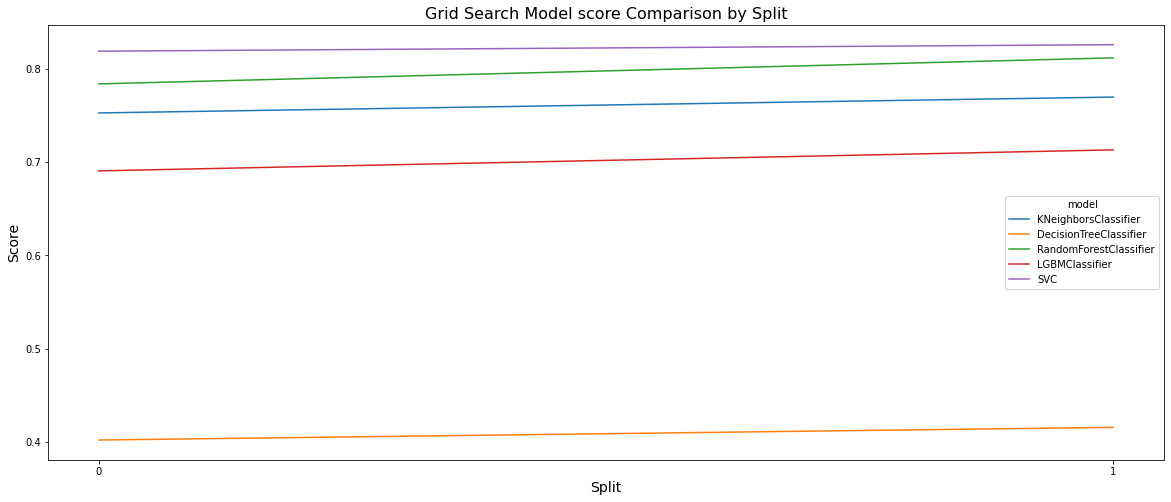

In [27]:
def get_split_scores(splits, grid_reg):
    scores = []
    models = []
    split_nums = []
    for i in range(splits):
        scores.append(grid_reg.cv_results_["split{}_test_score".format(i)][0])
        models.append(grid_reg.best_estimator_.__class__.__name__)
        split_nums.append(i)
    return split_nums, scores, models

splits = cv.cvargs["n_splits"]
fig, ax =plt.subplots(1,figsize=(20, 8))
plt.xticks(range(splits))
plt.xlabel("Split", fontsize=14)
plt.ylabel("Score", fontsize=14)
plt.title("Grid Search Model score Comparison by Split", fontsize=16)
scores = []
models = []
split_nums = []
for reg in grid_result:
    t_split, t_scores, t_models = get_split_scores(splits, reg)
    scores = np.append(scores, t_scores)
    models = np.append(models, t_models)
    split_nums = np.append(split_nums, t_split)
result = pd.DataFrame()
result["split"] = split_nums
result["model"] = models
result["score"] = scores
g = sns.lineplot(x=result.split, y=result.score, hue=result.model)
plt.show

## Best Scores

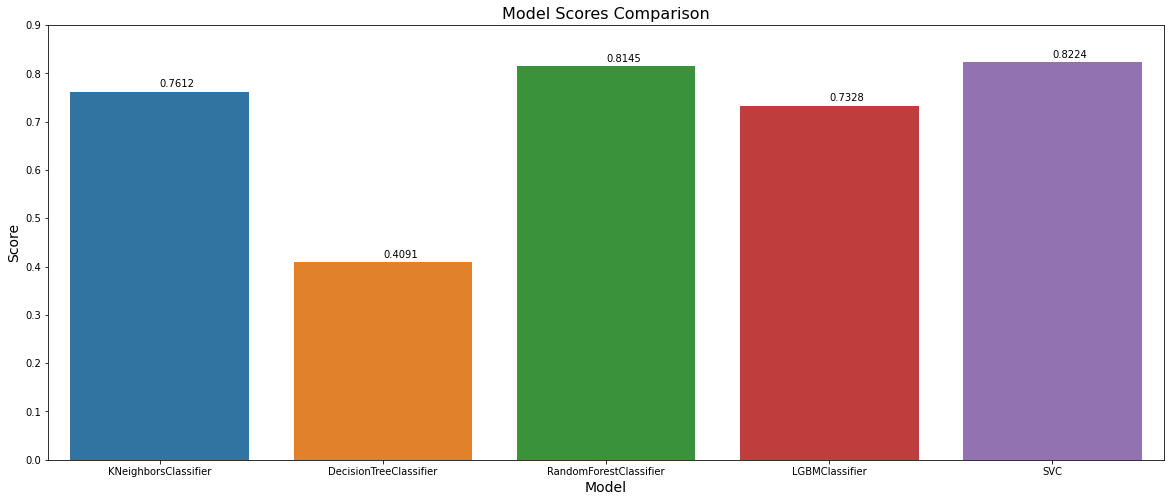

In [28]:
best_scores = [x.best_score_ for x in grid_result]
model_names = [x.best_estimator_.__class__.__name__ for x in grid_result]
fig, ax =plt.subplots(1,figsize=(20, 8))
g=sns.barplot(model_names, best_scores)
plt.title("Model Scores Comparison", fontsize=16)
plt.xlabel("Model", fontsize=14)
plt.ylabel("Score", fontsize=14)
plt.yticks(np.arange(0.0, 1.0, 0.1))

for i in range(len(model_names)):
    g.text(i, best_scores[i]+0.01, "{:0.4f}".format(best_scores[i]))

plt.show()

## Train final model

In [29]:
model = svm.SVC(random_state= random_state, decision_function_shape= 'ovo', degree= 3)
result = model.fit(train_X, train_Y, )

## Test model with Test Set

In [30]:
#pred = model.predict(test_X)
from sklearn.model_selection import cross_val_score
cross_val_score(model, test_X, test_Y, cv=2, scoring="f1_macro")

array([0.62942225, 0.66207964])

In [31]:
prediction = model.predict(test_X)

In [32]:
pred_labels = labelEncoder.inverse_transform(prediction)
pred_labels

array(['digit_4', 'digit_4', 'digit_4', ..., 'digit_4', 'digit_4',
       'digit_4'], dtype=object)

In [33]:
orig_labels = labelEncoder.inverse_transform(test_Y)

In [34]:
import random
rand = [random.randrange(0,len(test_Y)) for i in range(20)]

## Sample Predictions

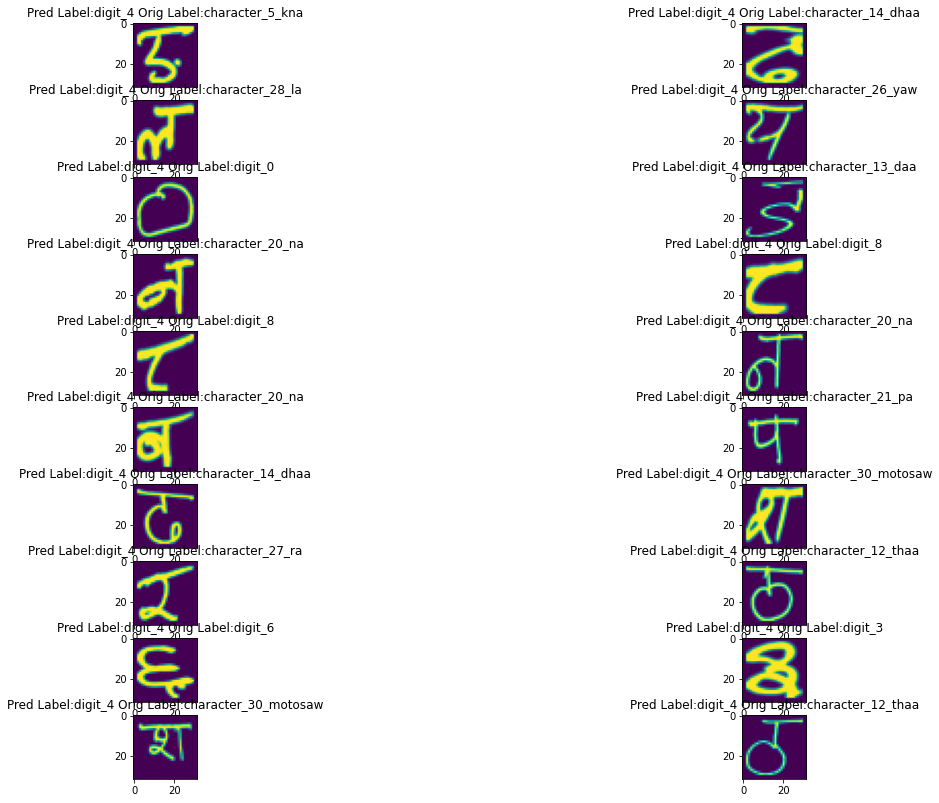

In [35]:
plt.figure(figsize=(20, 45))
for i in range(20):
    plt.subplot(32, 2, i+1)
    a = np.array(test_X.iloc[rand[i]][:1024], dtype='float')
    a = a.reshape(32,32)
    plt.title("Pred Label:{} Orig Label:{}".format(pred_labels[rand[i]], orig_labels[rand[i]]))
    plt.imshow(a)
plt.show()